**Integrantes: Fernanda Bravo- Belén Díaz-Esteban Gómez- Rodrigo Reyes**

## Caso de uso:
 -Análisis de productos: Evaluar cómo los usuarios persiben un producto en base a las reseñas dadas.

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from wordcloud import WordCloud #crea visualizaciones de nubes de palabras
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer #convierte colecciones de texto en cifras numericas
from sklearn.ensemble import RandomForestClassifier
from sklearn import metrics
from bs4 import BeautifulSoup #para realizar la limpieza de texto, en este caso elimina las etiquetas HTML presentes en las revisiones de productos
import re
import nltk
from nltk.corpus import stopwords
from gensim.models import Word2Vec

In [ ]:
#Cargamos el set de datos
# FAVOR DE REEMPLAZAR RUTA EN DONDE SE ENCUENTRE EL DATASET
df = pd.read_csv('/content/drive/MyDrive/Lab4/Cel_Reviews/Amazon_Unlocked_Mobile.csv')
df.head()

,Product Name,Brand Name,Price,Rating,Reviews,Review Votes
0,"""CLEAR CLEAN ESN"" Sprint EPIC 4G Galaxy SPH-D7...",Samsung,199.99,5,I feel so LUCKY to have found this used (phone...,1.0
1,"""CLEAR CLEAN ESN"" Sprint EPIC 4G Galaxy SPH-D7...",Samsung,199.99,4,"nice phone, nice up grade from my pantach revu...",0.0
2,"""CLEAR CLEAN ESN"" Sprint EPIC 4G Galaxy SPH-D7...",Samsung,199.99,5,Very pleased,0.0
3,"""CLEAR CLEAN ESN"" Sprint EPIC 4G Galaxy SPH-D7...",Samsung,199.99,4,It works good but it goes slow sometimes but i...,0.0
4,"""CLEAR CLEAN ESN"" Sprint EPIC 4G Galaxy SPH-D7...",Samsung,199.99,4,Great phone to replace my lost phone. The only...,0.0


Descripción del dataset: El dataset contiene 413.826 reseñas de teléfonos móviles desbloqueados vendidos en Amazon.com

In [ ]:
from tabulate import tabulate

# Resumen estadístico
print("Resumen estadístico:\n", tabulate(df.describe(), headers='keys', tablefmt='pretty'))


# Número total de reviews
print("\nNúmero total de reseñas: ", len(df))

# Número total de marcas únicas
print("\nNúmero total de marcas: ", len(list(set(df['Brand Name']))))

# Número total de productos únicos
print("\nNúmero total de productos únicos: ", len(list(set(df['Product Name']))))


Resumen estadístico:
 +-------+--------------------+--------------------+--------------------+
|       |       Price        |       Rating       |    Review Votes    |
+-------+--------------------+--------------------+--------------------+
| count |      407907.0      |      413840.0      |      401544.0      |
| mean  | 226.86715538100597 | 3.8195776145370193 | 1.5072370649293727 |
|  std  | 273.00625863510567 | 1.5482158148665002 | 9.163853131459716  |
|  min  |        1.73        |        1.0         |        0.0         |
|  25%  |       79.99        |        3.0         |        0.0         |
|  50%  |       144.71       |        5.0         |        0.0         |
|  75%  |       269.99       |        5.0         |        1.0         |
|  max  |       2598.0       |        5.0         |       645.0        |
+-------+--------------------+--------------------+--------------------+

Número total de reseñas:  413840

Número total de marcas:  385

Número total de productos únicos:  44

# Visualización de los datos

Text(0, 0.5, 'Cantidad')

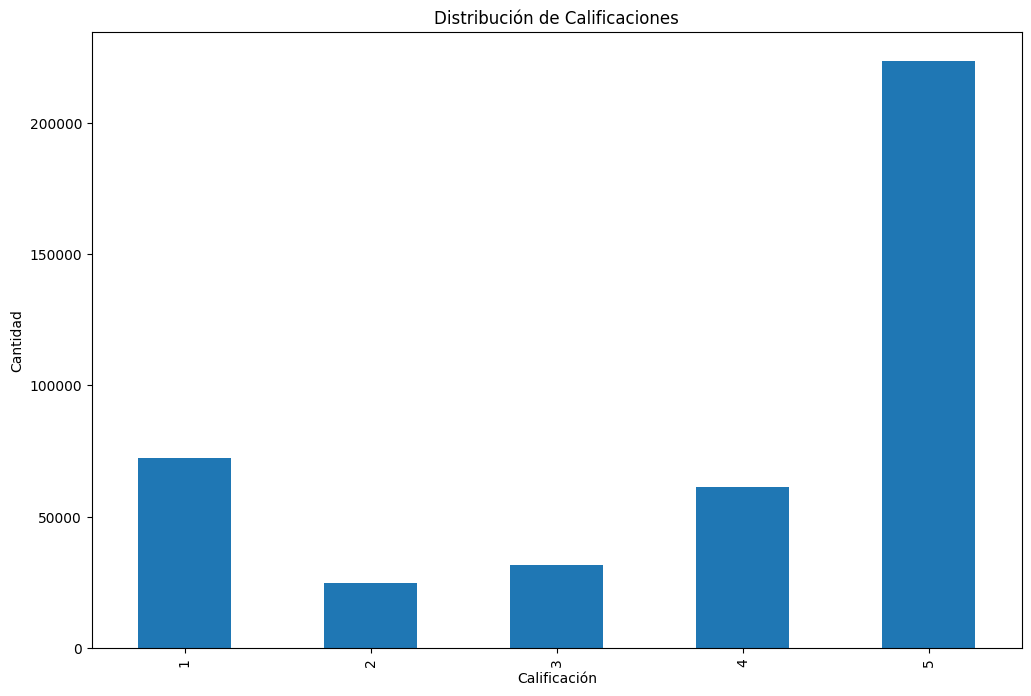

In [ ]:
# Gráfico de la distribución de calificaciones
plt.figure(figsize=(12,8))
# sns.countplot(df['Rating'])
df['Rating'].value_counts().sort_index().plot(kind='bar')
plt.title('Distribución de Calificaciones')
plt.xlabel('Calificación')
plt.ylabel('Cantidad')


Text(0.5, 1.0, 'Número de Reseñas para las 20 Principales Marcas')

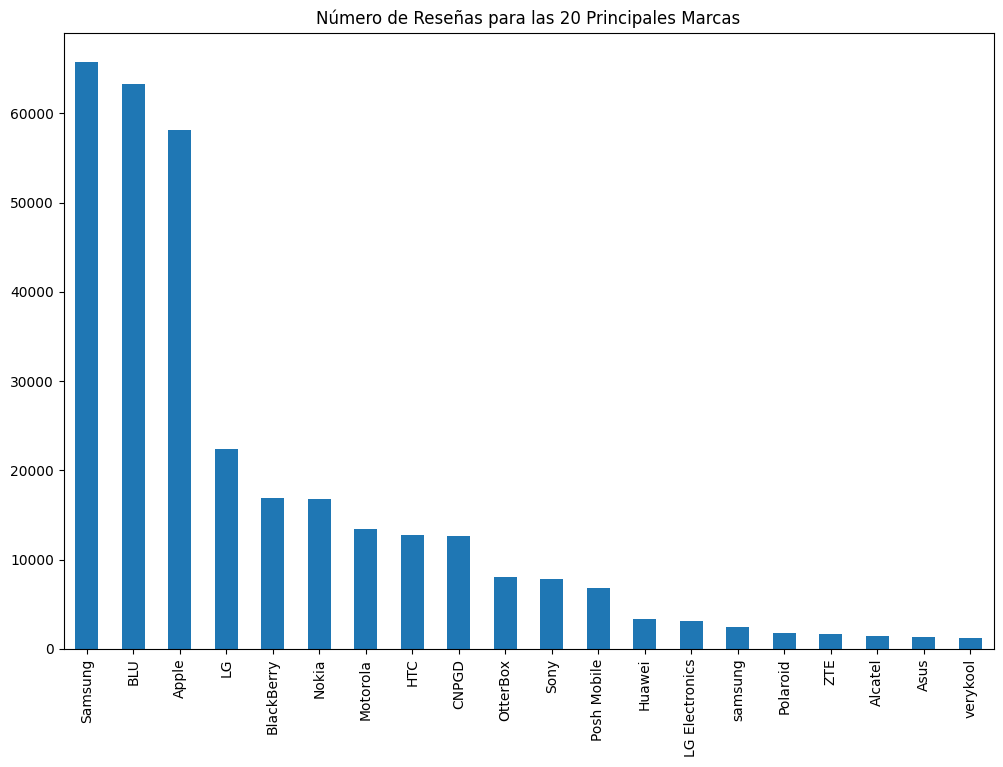

In [ ]:
# Gráfico del número de reseñas para las 20 principales marcas
marcas = df["Brand Name"].value_counts()
plt.figure(figsize=(12,8))
marcas[:20].plot(kind='bar')
plt.title("Número de Reseñas para las 20 Principales Marcas")


Text(0.5, 1.0, 'Número de Reseñas para los 50 Productos Principales')

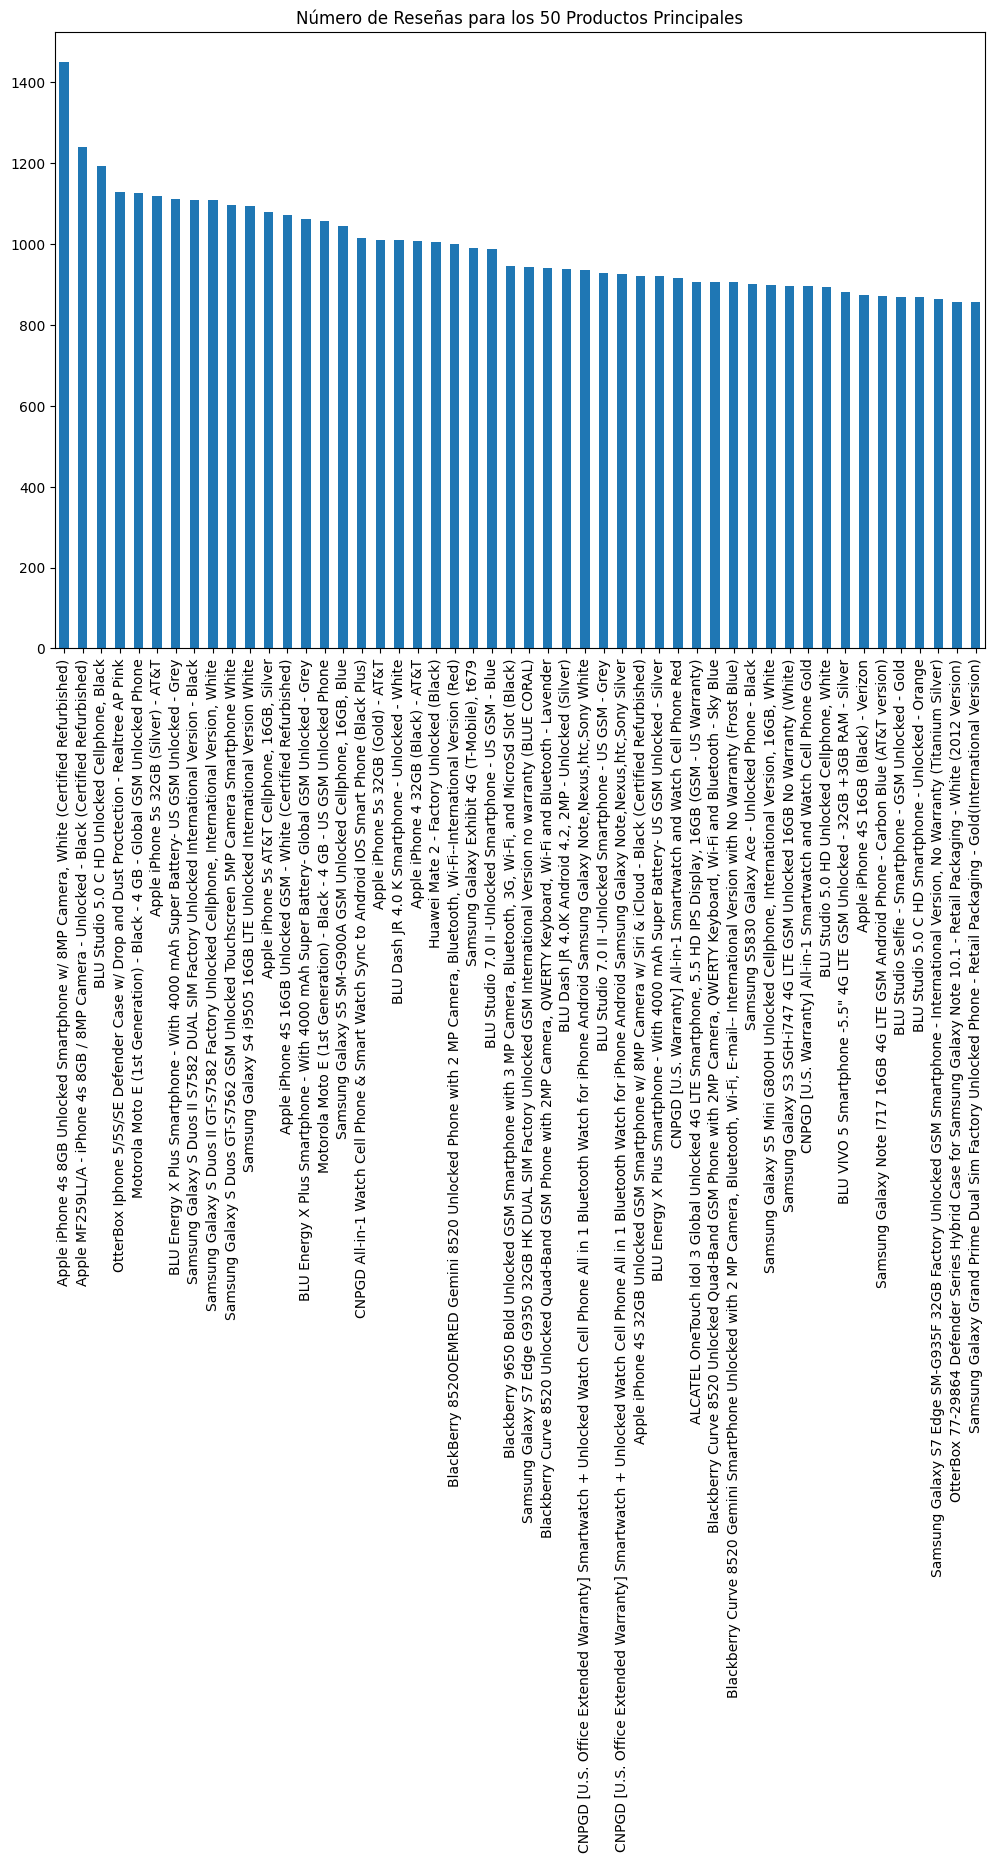

In [ ]:
# Gráfico del número de reseñas para los 50 productos principales
productos = df["Product Name"].value_counts()
plt.figure(figsize=(12,8))
productos[:50].plot(kind='bar')
plt.title("Número de Reseñas para los 50 Productos Principales")


Text(0, 0.5, 'Cantidad')

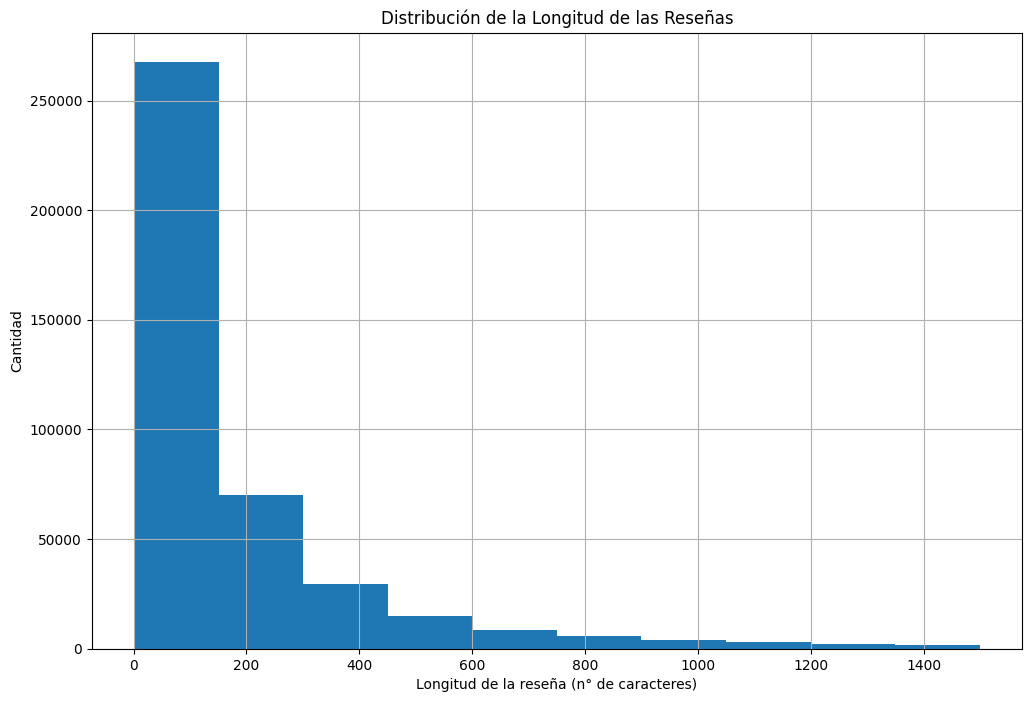

In [ ]:
#gráfico de la distribución de la longitud de las reseñas
longitud_resenas = df["Reviews"].dropna().map(lambda x: len(x))
plt.figure(figsize=(12,8))
longitud_resenas.loc[longitud_resenas < 1500].hist()
plt.title("Distribución de la Longitud de las Reseñas")
plt.xlabel('Longitud de la reseña (n° de caracteres)')
plt.ylabel('Cantidad')


# Preparación de los datos

In [ ]:
# Selecciona una muestra aleatoria del 10% del conjunto de datos
df = df.sample(frac=0.1, random_state=0)

# Elimina valores faltantes
df.dropna(inplace=True)

# Elimina calificaciones 'neutrales' iguales a 3
df = df[df['Rating'] != 3]

# Codifica las calificaciones 4 y 5 como 1 (sentimiento positivo) y las calificaciones 1 y 2 como 0 (sentimiento negativo)
df['Sentiment'] = np.where(df['Rating'] > 3, 1, 0)
df.head()


,Product Name,Brand Name,Price,Rating,Reviews,Review Votes,Sentiment
134801,BLU Studio 5.0 C HD - Unlocked Cell Phones - R...,BLU,2000.00,5,"For the price I paid for this devices, its fan...",0.0,1
123493,Blu LIFE 8 Unlocked (Pink),BLU,199.98,5,love love love it....good buy...recommend to a...,0.0,1
335592,Samsung Galaxy S Duos II S7582 DUAL SIM Factor...,Samsung,299.99,4,Good,0.0,1
246353,"Motorola Droid 2 A955 Verizon Phone 5MP Cam, W...",Motorola,82.00,1,Not good. Returned first phone and they sent m...,0.0,0
273324,Nokia Lumia 920 32GB Unlocked GSM 4G LTE Windo...,Nokia,149.35,4,Met expectations! I'm very satisfied!Even arri...,1.0,1


In [ ]:
# Divide los datos en conjuntos de entrenamiento y validación
X_train, X_test, y_train, y_test = train_test_split(df['Reviews'], df['Sentiment'], \
                                                    test_size=0.2, random_state=0)

# Imprime información sobre el número de ejemplos de entrenamiento y validación
print('Se cargaron %d ejemplos de entrenamiento y %d ejemplos de validación. \n' %(X_train.shape[0],X_test.shape[0]))

# Muestra una reseña en el conjunto de entrenamiento
print('Mostrar una reseña en el conjunto de entrenamiento: \n', X_train.iloc[10])

# Se muestra otra reseña en el conjunto de entrenamiento
print('\nMostrar otra reseña en el conjunto de entrenamiento: \n', X_train.iloc[322])


Se cargaron 24710 ejemplos de entrenamiento y 6178 ejemplos de validación. 

Mostrar una reseña en el conjunto de entrenamiento: 
 Actually everything was good the price, the sending time everything was absolutly perfect I loved it

Mostrar otra reseña en el conjunto de entrenamiento: 
 Product looks very good. I am happy.


#Procesamiento de texto

In [ ]:
from bs4 import BeautifulSoup
import re
from nltk.corpus import stopwords
from nltk.stem import SnowballStemmer

def cleanText(raw_text, remove_stopwords=False, stemming=False, split_text=False):
    #'''
    #Convierte una revisión cruda en una revisión limpia
    #'''
    # Elimina las etiquetas HTML usando BeautifulSoup
    text = BeautifulSoup(raw_text, 'lxml').get_text()

    # Elimina caracteres no alfabéticos
    letters_only = re.sub("[^a-zA-Z]", " ", text)

    # Convierte el texto a minúsculas y divide en palabras
    words = letters_only.lower().split()

    if remove_stopwords:  # Elimina palabras de parada (stopwords)
        stops = set(stopwords.words("english"))
        words = [w for w in words if not w in stops]

    if stemming:  # Realiza el proceso de stemming (reducción a la raíz)
        stemmer = SnowballStemmer('english')
        words = [stemmer.stem(w) for w in words]

    if split_text:  # Devuelve la lista de palabras en lugar de una cadena única
        return words

    return " ".join(words)


In [ ]:
# Preprocesar datos de texto en conjuntos de entrenamiento y validación
X_train_cleaned = []
X_test_cleaned = []

# Iterar sobre las revisiones en el conjunto de entrenamiento
for d in X_train:
    # Aplicar la función cleanText para limpiar y procesar la revisión
    X_train_cleaned.append(cleanText(d))

# Mostrar una revisión limpia en el conjunto de entrenamiento
print('Mostrar una revisión limpia en el conjunto de entrenamiento : \n',  X_train_cleaned[10])

# Iterar sobre las revisiones en el conjunto de validación
for d in X_test:
    # Aplicar la función cleanText para limpiar y procesar la revisión
    X_test_cleaned.append(cleanText(d))


<ipython-input-10-14f8b6ebbeb3>:11: MarkupResemblesLocatorWarning: The input looks more like a filename than markup. You may want to open this file and pass the filehandle into Beautiful Soup.
  text = BeautifulSoup(raw_text, 'lxml').get_text()
<ipython-input-10-14f8b6ebbeb3>:11: MarkupResemblesLocatorWarning: The input looks more like a URL than markup. You may want to use an HTTP client like requests to get the document behind the URL, and feed that document to Beautiful Soup.
  text = BeautifulSoup(raw_text, 'lxml').get_text()


Mostrar una revisión limpia en el conjunto de entrenamiento : 
 actually everything was good the price the sending time everything was absolutly perfect i loved it


In [ ]:
#Necesaria para descarga de datos necesarios para el tokenizador de NLTK.
import nltk
nltk.download('punkt')


[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


True

In [ ]:
# Word2Vec
# Cargar el tokenizador punkt de NLTK
tokenizer = nltk.data.load('tokenizers/punkt/english.pickle')

def parseSent(review, tokenizer, remove_stopwords=False):

    # Tokenizar el texto en oraciones utilizando el tokenizador cargado
    raw_sentences = tokenizer.tokenize(review.strip())

    # Inicializar una lista para almacenar las oraciones procesadas
    sentences = []

    # Iterar sobre las oraciones tokenizadas
    for raw_sentence in raw_sentences:
        # Verificar si la oración tiene longitud mayor que cero
        if len(raw_sentence) > 0:
            # Limpiar y procesar la oración utilizando la función cleanText
            sentences.append(cleanText(raw_sentence, remove_stopwords, split_text=True))

    return sentences

# Parsear cada revisión en el conjunto de entrenamiento en oraciones
sentences = []
for review in X_train_cleaned:
    # Agregar las oraciones procesadas a la lista de oraciones
    sentences += parseSent(review, tokenizer)

# Mostrar el número de oraciones procesadas en el conjunto de entrenamiento
print('%d oraciones analizadas en el conjunto de entrenamiento\n'  %len(sentences))
# Mostrar una oración procesada en el conjunto de entrenamiento
print('Mostrar una oración analizada en el conjunto de entrenamiento : \n',  sentences[10])


24684 oraciones analizadas en el conjunto de entrenamiento

Mostrar una oración analizada en el conjunto de entrenamiento : 
 ['actually', 'everything', 'was', 'good', 'the', 'price', 'the', 'sending', 'time', 'everything', 'was', 'absolutly', 'perfect', 'i', 'loved', 'it']


In [ ]:
num_features = 300  # Dimensión del embedding
min_word_count = 10  # Mínimo de ocurrencias de una palabra para ser considerada en el vocabulario
num_workers = 4  # Número de núcleos para entrenar el modelo
context = 10  # Tamaño de la ventana contextual
downsampling = 1e-3  # Reducción de muestreo

print("Entrenando el modelo Word2Vec...\n")
w2v = Word2Vec(sentences, workers=num_workers, vector_size=num_features, min_count=min_word_count, window=context, sample=downsampling)
w2v.save("w2v_300features_10minwordcounts_10context")  # Guarda el modelo Word2Vec entrenado

print("Número de palabras en la lista de vocabulario: %d \n" % len(w2v.wv.index_to_key))
print("Mostrar las primeras 10 palabras en la lista de vocabulario: \n", w2v.wv.index_to_key[0:10])


Entrenando el modelo Word2Vec...

Número de palabras en la lista de vocabulario: 3804 

Mostrar las primeras 10 palabras en la lista de vocabulario: 
 ['the', 'i', 'it', 'and', 'phone', 'a', 'to', 'is', 'this', 'for']


HASTA ACA

In [ ]:
import nltk
nltk.download('stopwords')


[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


True

In [ ]:
def makeFeatureVec(review, model, num_features):
    '''
    Transforma una reseña en un vector de características promediando los vectores de características de las palabras
    que aparecieron en esa reseña y en la lista de vocabulario creada.
    '''
    featureVec = np.zeros((num_features,), dtype="float32")
    nwords = 0.
    for word in review:
        if word in model.wv.key_to_index:
            nwords = nwords + 1.
            featureVec = np.add(featureVec, model.wv[word])
    if nwords > 0:
        featureVec = np.divide(featureVec, nwords)
    return featureVec

def getAvgFeatureVecs(reviews, model, num_features):
    counter = 0
    reviewFeatureVecs = np.zeros((len(reviews), num_features), dtype="float32")
    for review in reviews:
        reviewFeatureVecs[counter] = makeFeatureVec(review, model, num_features)
        counter = counter + 1
    return reviewFeatureVecs

# Obtener vectores de características para el conjunto de entrenamiento
X_train_cleaned = [cleanText(review, remove_stopwords=True, split_text=True) for review in X_train]
trainVector = getAvgFeatureVecs(X_train_cleaned, w2v, num_features)
print("\nConjunto de entrenamiento: %d vectores de características con %d dimensiones" % trainVector.shape)

# Obtener vectores de características para el conjunto de validación
X_test_cleaned = [cleanText(review, remove_stopwords=True, split_text=True) for review in X_test]
testVector = getAvgFeatureVecs(X_test_cleaned, w2v, num_features)
print("\nConjunto de validación: %d vectores de características con %d dimensiones" % testVector.shape)


<ipython-input-10-14f8b6ebbeb3>:11: MarkupResemblesLocatorWarning: The input looks more like a filename than markup. You may want to open this file and pass the filehandle into Beautiful Soup.
  text = BeautifulSoup(raw_text, 'lxml').get_text()
<ipython-input-10-14f8b6ebbeb3>:11: MarkupResemblesLocatorWarning: The input looks more like a URL than markup. You may want to use an HTTP client like requests to get the document behind the URL, and feed that document to Beautiful Soup.
  text = BeautifulSoup(raw_text, 'lxml').get_text()



Conjunto de entrenamiento: 24710 vectores de características con 300 dimensiones

Conjunto de validación: 6178 vectores de características con 300 dimensiones


In [ ]:
from sklearn.metrics import classification_report, accuracy_score

# Random Forest Classifier
rf = RandomForestClassifier(n_estimators=100, random_state=42)
rf.fit(trainVector, y_train)
predictions = rf.predict(testVector)

# Evaluar el modelo - Accuracy y Classification Report
accuracy = accuracy_score(y_test, predictions)
print(f'Accuracy: {accuracy:.2f}\n')

classification_rep = classification_report(y_test, predictions)
print('Classification Report:\n', classification_rep)


Accuracy: 0.91

Classification Report:
               precision    recall  f1-score   support

           0       0.86      0.79      0.82      1580
           1       0.93      0.96      0.94      4598

    accuracy                           0.91      6178
   macro avg       0.89      0.87      0.88      6178
weighted avg       0.91      0.91      0.91      6178



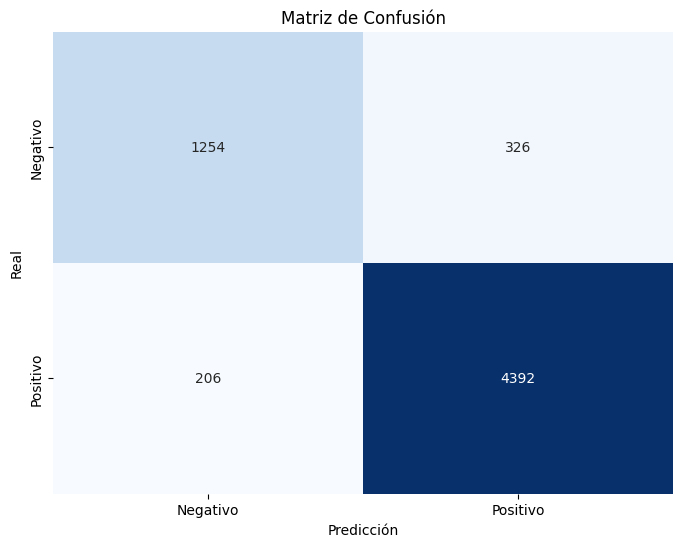

In [ ]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

# Matriz de Confusión
conf_matrix = confusion_matrix(y_test, predictions)

# Visualización atractiva de la Matriz de Confusión
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', cbar=False,
            xticklabels=['Negativo', 'Positivo'],
            yticklabels=['Negativo', 'Positivo'])
plt.title('Matriz de Confusión')
plt.xlabel('Predicción')
plt.ylabel('Real')
plt.show()


In [ ]:
def create_word_cloud(brand, sentiment):
    try:
        # Filtrar el DataFrame por la marca seleccionada
        df_brand = df.loc[df['Brand Name'].isin([brand])]

        # Tomar una muestra del 10% de las reseñas de la marca
        df_brand_sample = df_brand.sample(frac=0.1)
        word_cloud_collection = ''

        # Filtrar por sentimiento positivo
        if sentiment == 1:
            df_reviews = df_brand_sample[df_brand_sample["Sentiment"]==1]["Reviews"]

        # Filtrar por sentimiento negativo
        if sentiment == 0:
            df_reviews = df_brand_sample[df_brand_sample["Sentiment"]==0]["Reviews"]

        # Procesar y agregar palabras al conjunto para la nube de palabras
        for val in df_reviews.str.lower():
            tokens = nltk.word_tokenize(val)
            tokens = [word for word in tokens if word not in stopwords.words('english')]
            for words in tokens:
                word_cloud_collection = word_cloud_collection + words + ' '

        # Crear y mostrar la nube de palabras
        wordcloud = WordCloud(max_font_size=50, width=500, height=300).generate(word_cloud_collection)
        plt.figure(figsize=(20,20))
        plt.imshow(wordcloud)
        plt.axis("off")
        plt.show()
    except Exception as e:
        # Manejar excepciones (puedes imprimir o registrar el error)
        print(f"Error al crear la nube de palabras: {str(e)}")


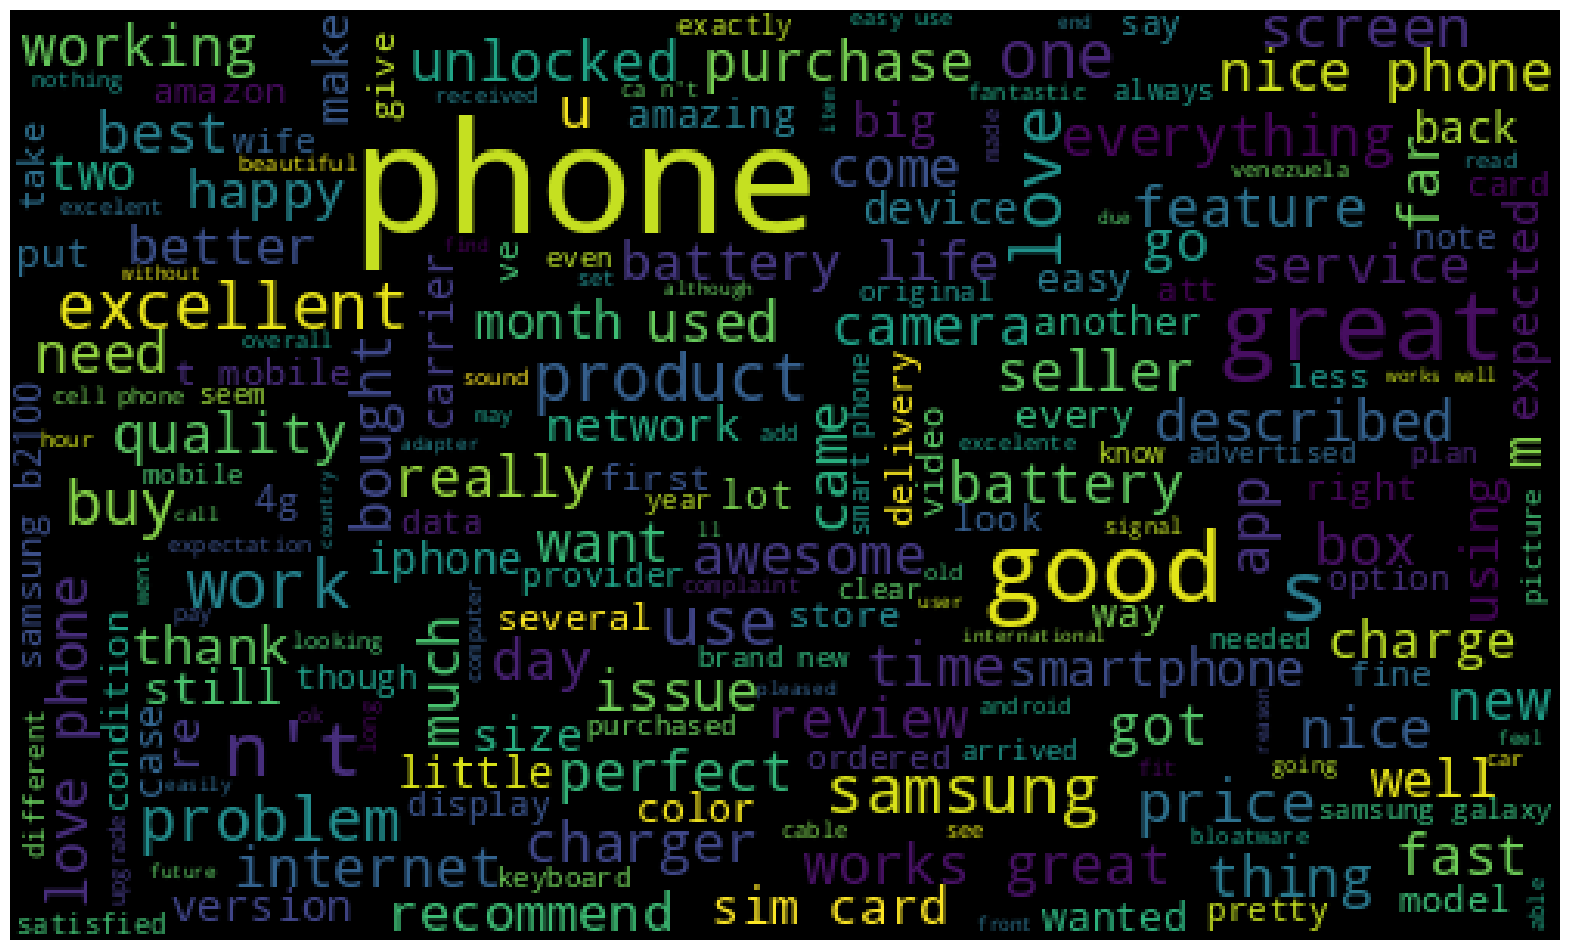

In [ ]:
create_word_cloud(brand='Samsung', sentiment=1)


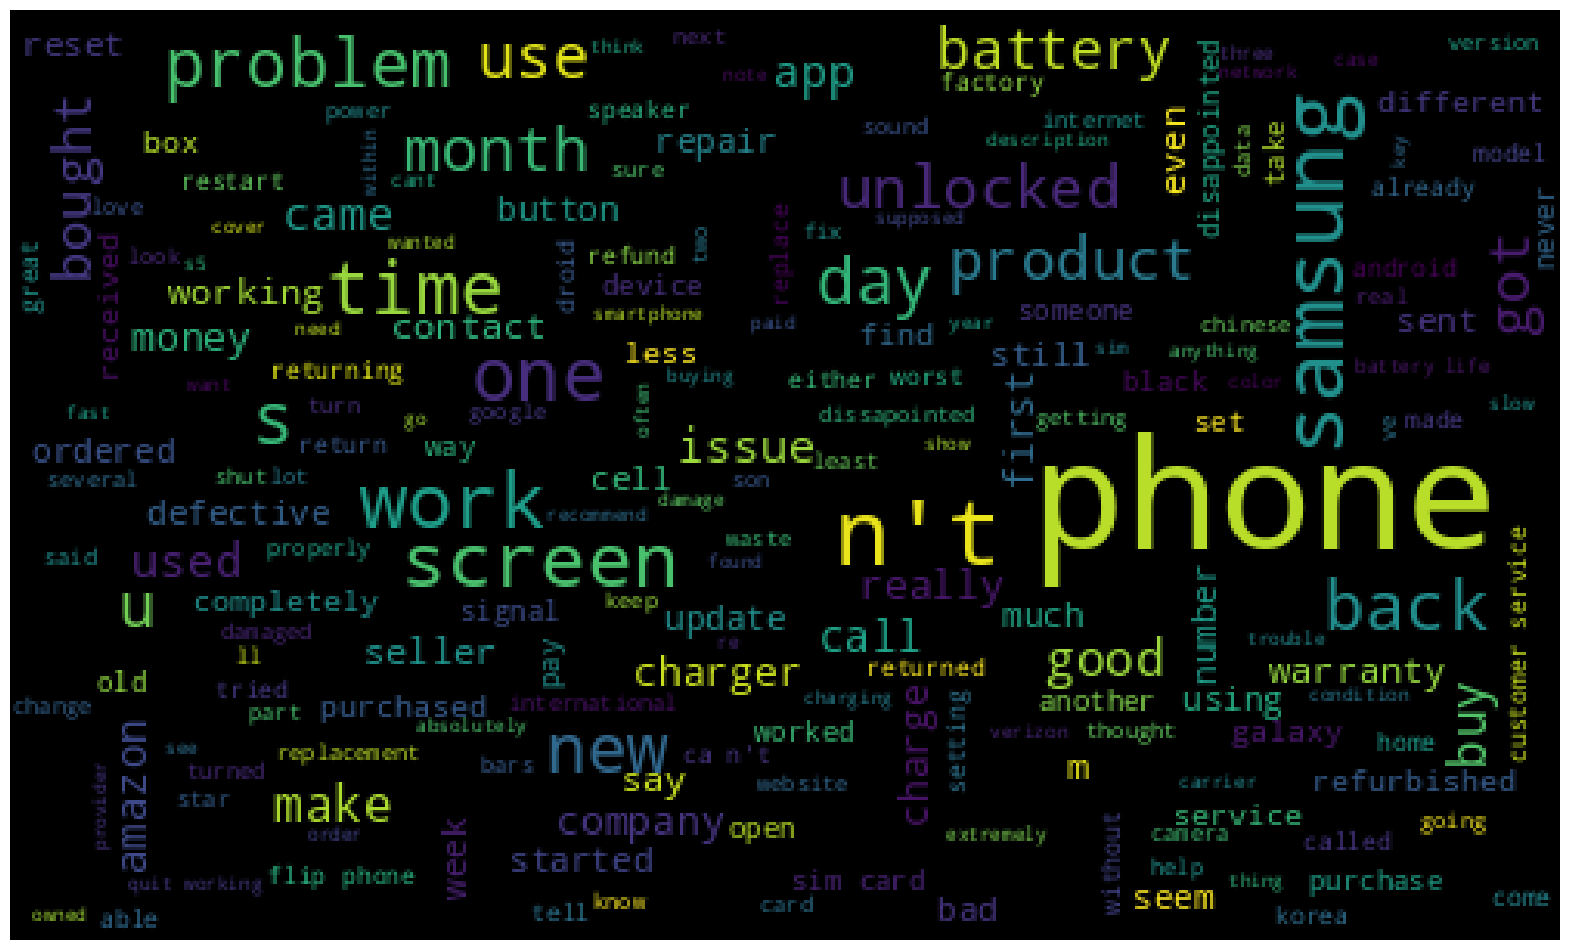

In [ ]:
create_word_cloud(brand='Samsung', sentiment=0)


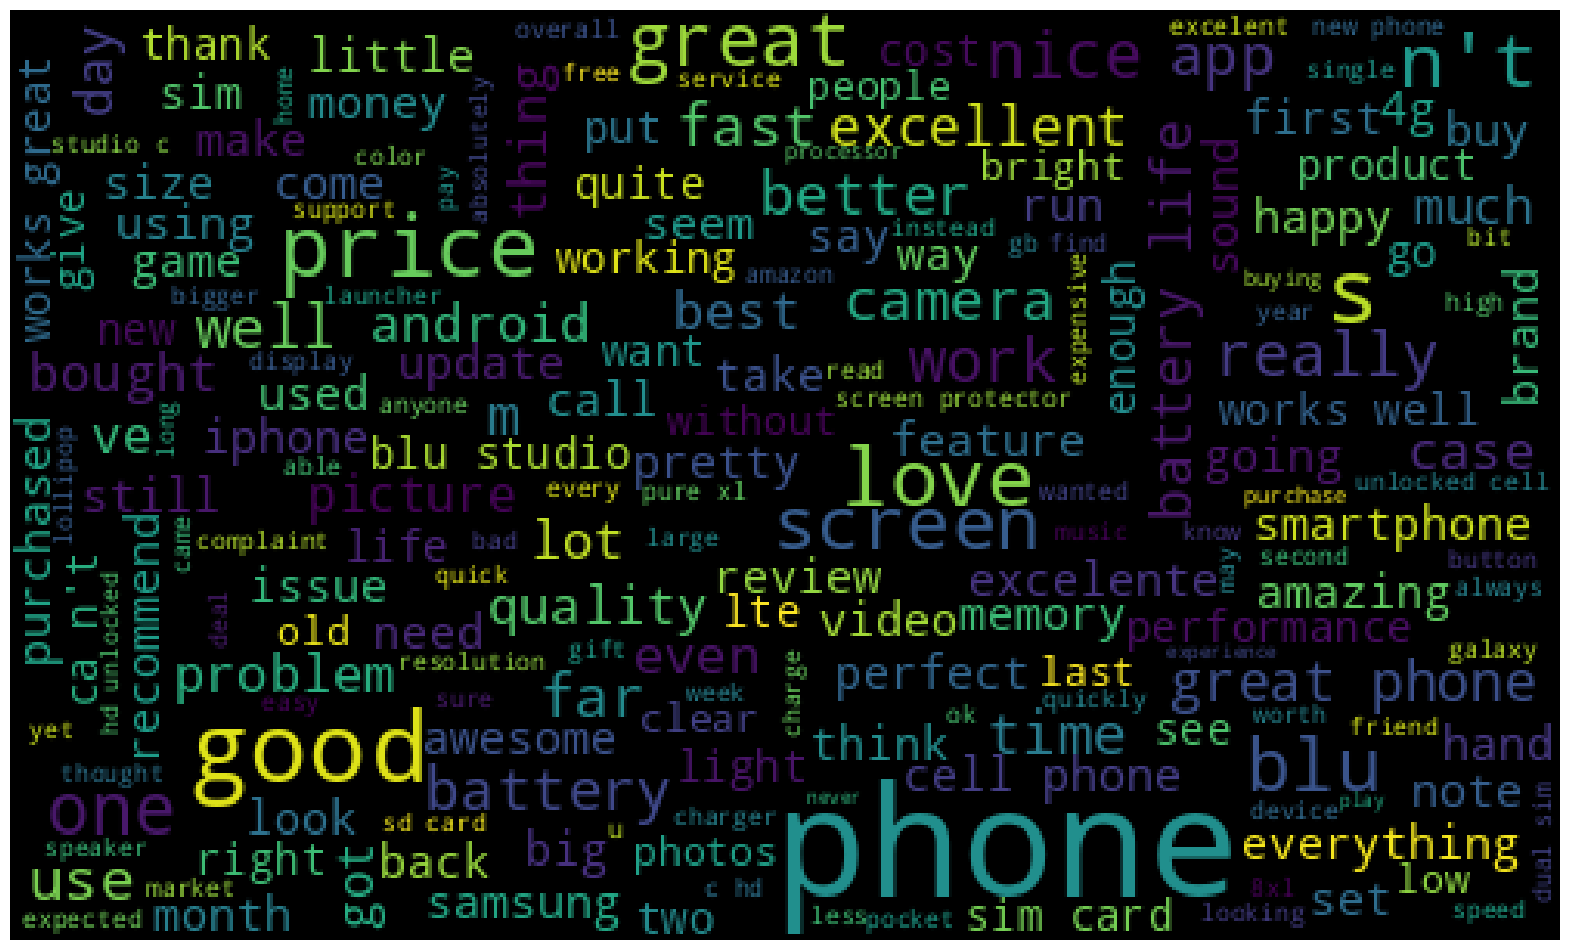

In [ ]:
create_word_cloud(brand='BLU', sentiment=1)


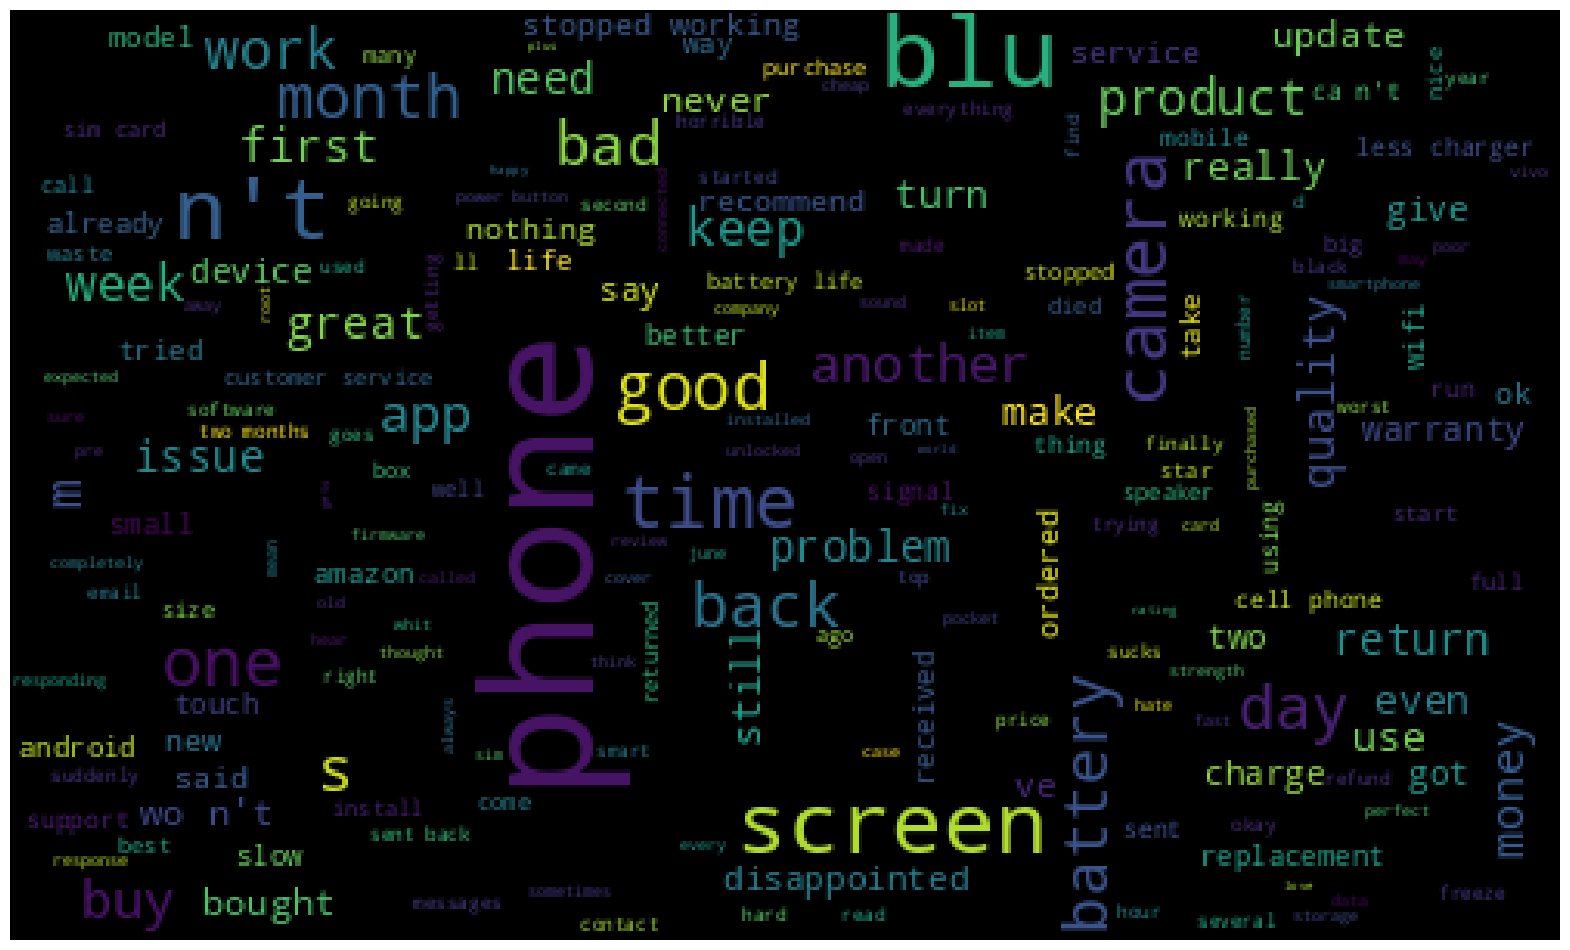

In [ ]:
create_word_cloud(brand='BLU', sentiment=0)


In [ ]:
pip install plotly


In [ ]:
pip install prettytable


In [ ]:
import plotly.graph_objects as go

# Calcular la cantidad de comentarios negativos y positivos para cada marca
brand_sentiment_table = df.groupby(['Brand Name', 'Sentiment']).size().unstack().fillna(0)
brand_sentiment_table['Total Negativos'] = brand_sentiment_table[0]
brand_sentiment_table['Total Positivos'] = brand_sentiment_table[1]

# Calcular la percepción general y asignar comentarios
comments = []

for index, row in brand_sentiment_table.iterrows():
    total_reviews = row['Total Negativos'] + row['Total Positivos']
    positive_percentage = row['Total Positivos'] / total_reviews if total_reviews > 0 else 0

    # Definir umbral para la percepción general (puedes ajustarlo según tus preferencias)
    threshold = 0.66

    if positive_percentage > threshold:
        comment = "Buen producto"
    elif positive_percentage < 1 - threshold:
        comment = "Mal producto"
    else:
        comment = "Opiniones mixtas"

    comments.append(comment)

# Crear una tabla interactiva con comentarios
fig = go.Figure(data=[go.Table(
    header=dict(values=['Marca', 'Negativos', 'Positivos', 'Comentario']),
    cells=dict(values=[brand_sentiment_table.index,
                       brand_sentiment_table['Total Negativos'],
                       brand_sentiment_table['Total Positivos'],
                       comments])
)])

# Establecer el diseño de la tabla
fig.update_layout(title='Tabla de Calificaciones por Marca',
                  title_font_size=24,
                  title_x=0.5)

# Mostrar la tabla interactiva
fig.show()
